In [1]:
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from tqdm.notebook import tqdm, trange
import torch
import autograd.numpy as np
import autograd.scipy.stats as stats
import scipy.optimize as optimize
from autograd.scipy.linalg import logm
from autograd import grad, jacobian, hessian
import numpy
import scipy
import pandas as pd
import ipywidgets as widgets
import time
from sklearn import linear_model

In [2]:
def decode_q_params(encoded_q):
        shape = len(encoded_q)
        mean_shape = 3
        A_shape = (int(np.sqrt(shape - mean_shape)), int(np.sqrt(shape - mean_shape)))
        mean = encoded_q[0:mean_shape]
        A = encoded_q[mean_shape:shape].reshape(A_shape)
        return mean, A
def encode_q_params(q_params):
    mean, A = q_params
    return np.array(list(mean) + list(A.flatten()))

def decode_d(encoded_d, dim=2):
    return encoded_d.reshape(int(len(encoded_d)/dim), dim)
def encode_d(d):
    return d.flatten()

def augment_d(d):
    return np.concatenate((d.T, [np.ones(len(d))]), axis=0).T

In [3]:
def stable_multivariate_gaussian_logpdf(x, mu, cov):
    n = cov.shape[-1]
    x_mu = x - mu
    try:
        _, log_det = np.linalg.slogdet(cov)
        cov_inv = np.linalg.inv(cov)
        prod = np.einsum('...i, ...ij, ...j->...', x_mu, cov_inv, x_mu) # todo: find a way to make this understandable
        log_prob = -0.5 * (n * np.log(2 * np.pi) + log_det + prod)
    except np.linalg.LinAlgError:
        cov_modified = cov + np.eye(n) * 1e-8
        _, log_det = np.linalg.slogdet(cov_modified)
        cov_inv = np.linalg.inv(cov_modified)
        prod = np.einsum('...i, ...ij, ...j->...', x_mu, cov_inv, x_mu)
        log_prob = -0.5 * (n * np.log(2 * np.pi) + log_det + prod)
    return log_prob

In [4]:
def get_posterior(d, y_i):
    d = np.concatenate((d, np.array([np.ones(d.shape[0])]).T), axis=1)
    var_y = np.var(y_i) * np.eye(len(y_i))
    covariance_prior = A_prior @ A_prior.T
    mean_theta = covariance_prior @ d.T @ np.linalg.inv(var_y + d @ covariance_prior @ d.T) @ y_i
    cov_theta = covariance_prior - covariance_prior @ d.T @ np.linalg.inv(var_y + d @ covariance_prior @ d.T) @ d @ covariance_prior
    return mean_theta, np.linalg.cholesky(cov_theta)
def get_posteriors(d, y):
    d = augment_d(d)
    var_y = noise * np.eye(y.shape[1])
    covariance_prior = A_prior @ A_prior.T
    mean_theta = covariance_prior @ d.T @ np.linalg.inv(var_y + d @ covariance_prior @ d.T) @ y.T
    cov_theta = covariance_prior - covariance_prior @ d.T @ np.linalg.inv(var_y + d @ covariance_prior @ d.T) @ d @ covariance_prior
    return mean_theta, np.linalg.cholesky(cov_theta)

In [283]:
#d0 = np.random.randn(20,2)
d0 = np.array([[i,i] for i in range(10)])
#A_prior = np.array([[5, -2, 1],
#              [-2, 4, -1],
#              [1, -1, 3]])
A_prior = np.eye(3)
mean_prior = np.array([0,0, 0])
noise = 1

In [277]:
theta = np.random.multivariate_normal(mean_prior, A_prior @ A_prior.T)
theta2 = np.random.multivariate_normal(mean_prior, A_prior @ A_prior.T)

z = np.random.randn(d0.shape[0]) * noise
z2 = np.random.randn(d0.shape[0]) * noise
print(get_posterior(d0, theta @ augment_d(d0).T + z))
print(get_posteriors(np.array(d0), np.array([theta @ augment_d(d0).T + z, theta2 @ augment_d(d0).T + z2])))

(array([-0.18586444, -0.18586444,  0.56702076]), array([[ 0.71612038,  0.        ,  0.        ],
       [-0.68029287,  0.22367389,  0.        ],
       [-0.09136528, -0.57040043,  0.38723677]]))
(array([[-0.18060982, -1.01518623],
       [-0.18060982, -1.01518623],
       [ 0.52959842, -0.52816809]]), array([[ 0.71686044,  0.        ,  0.        ],
       [-0.67811123,  0.23249528,  0.        ],
       [-0.09687303, -0.58123819,  0.40824829]]))


In [261]:
def MI(d, N=50):
    thetas = np.random.multivariate_normal(mean_prior, A_prior @ A_prior.T, size=N)
    z = np.random.randn(N, d.shape[0]) * noise
    y = thetas @ augment_d(d).T + z
    mean, A = get_posteriors(d, y)
    #print(mean.T)
    results = [stable_multivariate_gaussian_logpdf(theta_i, mean_i, A @ A.T) for theta_i, mean_i in zip(thetas, mean.T)]
    return 1/N * np.sum(results) - 0.5 * np.log(np.linalg.det(2 * np.pi * np.e * (A_prior @ A_prior.T)))

In [288]:
cov_prior = A_prior @ A_prior.T
def mutual_information(d):
    N = 10 # amount of theta samples
    M = 5 # amount of z samples
    thetas = np.random.multivariate_normal(mean_prior, cov_prior, N)
    results = []
    for theta in thetas:
        zs = np.random.randn(M)
        ys = np.array([augment_d(d) @ theta + noise * z for theta in thetas for z in zs])
        for y in ys:
            mean, A = get_posterior(d, y)
            log_posterior = stable_multivariate_gaussian_logpdf(theta, mean, A @ A.T) # using posterior_distribution from last week
            log_prior = stable_multivariate_gaussian_logpdf(theta, mean_prior, cov_prior)
            results.append(log_posterior - log_prior)
    return 1/(N * M) * np.sum(results)

In [263]:
def slide_MI(d):
    def log_likelihood(y, theta, d):
        return stable_multivariate_gaussian_logpdf(y, d @ theta, noise * np.eye(len(y)))
    N = 10 # amount of theta samples
    M = 10 # amount of z samples
    thetas = np.random.multivariate_normal(mean_prior, cov_prior, N)
    results = []
    zs = np.random.randn(M)
    ys = np.array([augment_d(d) @ theta + noise * z for theta in thetas for z in zs])
    def inner_loop(j):
        return [np.exp(log_likelihood(ys[j], thetas[i], augment_d(d))) for i in range(N)]
    def outer_loop():
        return [np.log(np.sum(inner_loop(j))) for j in range(M)]
    return -0.5 * np.log(2 * np.pi * np.e * np.linalg.det(noise * np.eye(d.shape[1]))) - 1/N * np.sum(outer_loop())

In [264]:
first_mi = slide_MI(d0)
g = grad(slide_MI)(d0)
second_mi = slide_MI(d0 - g)
print(first_mi, second_mi, g)

1.4421553860474385 0.7563673373160569 [[ 0.29103275 -0.38381763]
 [ 0.07908734 -0.07071865]
 [-0.13285806  0.24238033]]


In [265]:
def optimizer(x0, gradient, callback=lambda x, g: True, rate=1, decay=0.5, iters=1e1, label=None, leave=True, thres=0.1):
    x = x0
    for i in tqdm(range(int(iters)), desc=label, leave=leave):
        r = rate * 1/(10+i*decay)
        g = gradient(x)
        x = -g * r + x
        #if i > 0 and np.linalg.norm(g) < thres or np.linalg.norm(g) > 10:
        #    break
        if i % 1 == 0:
            if not callback(x, g):
                break
    return x

In [289]:
dis = []
mis = []
def callback(di, g):
    dis.append(decode_d(di))
    return True
def g(encoded_d):
    d = decode_d(encoded_d)
    g_ = MI(d)
    mis.append(g_._value)
    return -g_
optimizer(encode_d(d0), grad(g), rate=1, decay=0.0001, iters=100000, callback=callback)
dis = np.array(dis)

  0%|          | 0/100000 [00:00<?, ?it/s]

KeyboardInterrupt: 

Text(0, 0.5, 'MI')

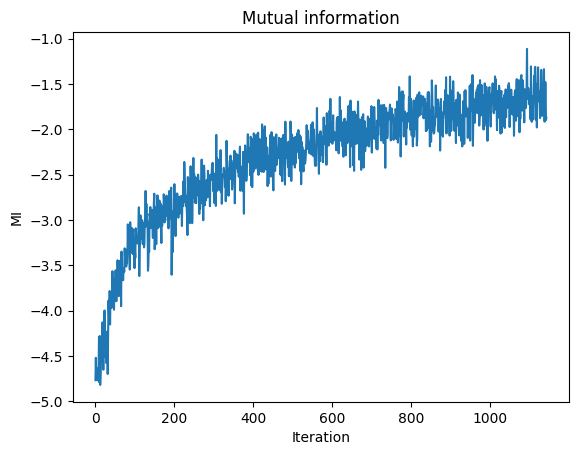

In [290]:
plt.plot(np.arange(0, len(mis)), mis)
#plt.yscale('log')
plt.title("Mutual information")
plt.xlabel("Iteration")
plt.ylabel("MI")

Text(0, 0.5, 'MI')

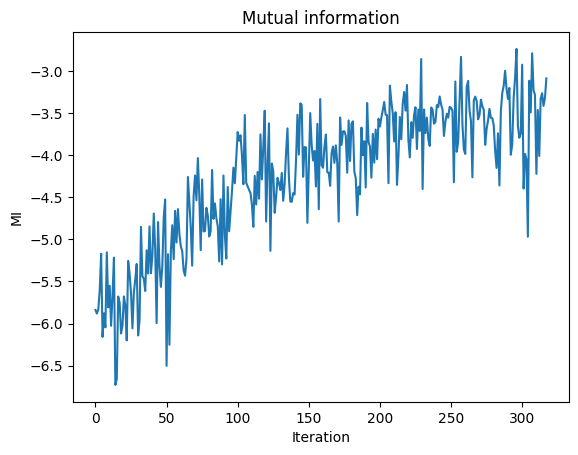

In [280]:
def analytical_mutual_information(d, dim=3): # From week 2
    covariance_prior = A_prior @ A_prior.T
    var_y = noise * np.eye(d.shape[0])
    cov_posterior = covariance_prior - covariance_prior @ d.T @ np.linalg.inv(var_y + d @ covariance_prior @ d.T) @ d @ covariance_prior
    #val = 0.5 * np.log(np.linalg.det(2*np.pi*np.e*cov_posterior)) - 0.5 * np.log(np.linalg.det(2*np.pi*np.e*covariance_prior))
    return 0.5 * np.log(np.linalg.det(2*np.pi*np.e*cov_posterior))
plt.plot(np.arange(0, len(dis)), np.array([MI(d, N=10) for d in dis]))
#plt.yscale('log')
plt.title("Mutual information")
plt.xlabel("Iteration")
plt.ylabel("MI")

Text(0, 0.5, 'Norm of d')

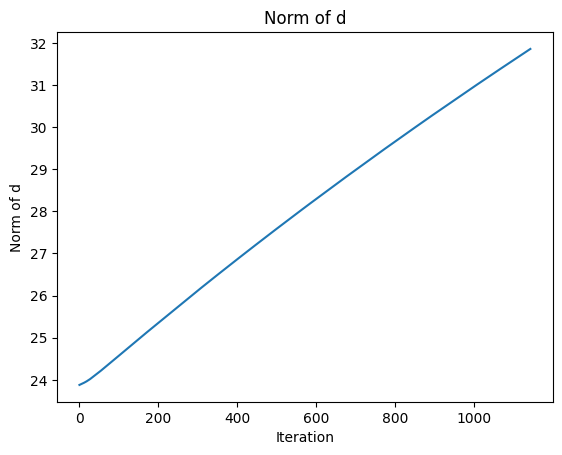

In [291]:
plt.plot(np.arange(0, len(dis)), np.array([np.linalg.norm(d) for d in dis]))
#plt.yscale('log')
plt.title("Norm of d")
plt.xlabel("Iteration")
plt.ylabel("Norm of d")

Text(0.5, 1.0, '$d$ at iteration 0')

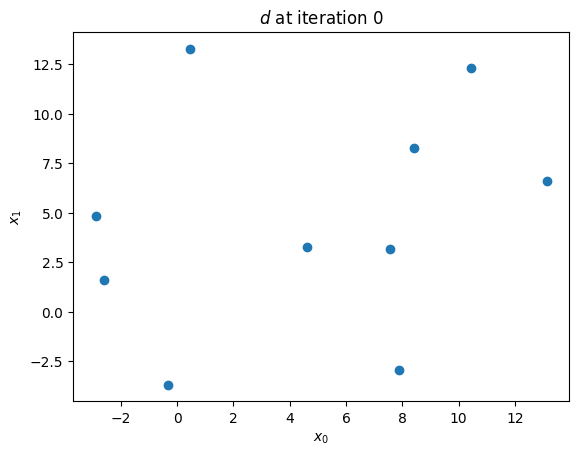

In [293]:
i = -1
di = dis[i]
plt.xlabel("$x_0$")
plt.ylabel("$x_1$")
plt.scatter(di[:, 0], di[:, 1])
plt.title("$d$ at iteration %d" % (i + 1))

Text(0.5, 1.0, 'Points move per iteration (blue is start, orange is end)')

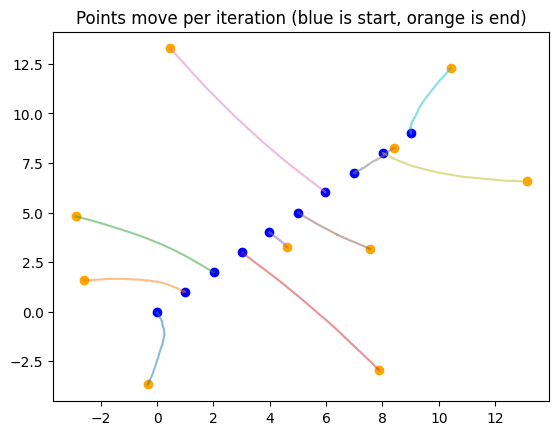

In [292]:
dis = np.array(dis)
for p in range(d0.shape[0]):
    plt.scatter(dis[0, p, 0], dis[0, p, 1], c="blue") # start
    plt.scatter(dis[-1, p, 0], dis[-1, p, 1], c="orange") # end
    plt.plot(dis[:, p, 0], dis[:, p, 1], alpha=0.5)
plt.title("Points move per iteration (blue is start, orange is end)")

In [174]:
from sklearn import feature_selection


<function sklearn.feature_selection._mutual_info.mutual_info_regression(X, y, *, discrete_features='auto', n_neighbors=3, copy=True, random_state=None)>

In [176]:
feature_selection.mutual_info_regression(d0, augment_d(d0) @ mean_prior)

array([0.14043932, 0.16668446])

In [177]:
d0

array([[ 0.91216775, -1.23573429],
       [-0.05942965, -0.94065035],
       [-1.42813899,  0.15096409],
       [ 0.18241371,  0.59576571],
       [-0.52071789, -0.21772777],
       [-0.64335664, -1.73942654],
       [ 2.68876822,  0.93348434],
       [ 0.25332059, -0.36764094],
       [ 1.30960781,  0.12347668],
       [-0.90743264,  0.96283309],
       [ 0.22951679, -0.65598932],
       [ 0.28064163,  1.32302002],
       [ 0.63656597,  2.83895363],
       [ 0.10610745,  0.53807632],
       [ 1.17501036,  1.83639267],
       [ 0.45178224,  0.89895888],
       [ 3.34984703,  0.91162536],
       [ 1.52752355,  0.05167035],
       [-0.02442964, -1.29329262],
       [ 1.92539853,  0.44669437]])